In [3]:
import numpy as np
import torch as th
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.io import read_image
from pathlib import Path
import cv2

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (20, 20)   # figsize

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def face_segment(segment_part, img):
    
    if isinstance(img, Image.Image):
        face_segment_anno = np.array(img)
    else:
        face_segment_anno = img
        
    bg = (face_segment_anno == 0)
    skin = (face_segment_anno == 1)
    l_brow = (face_segment_anno == 2)
    r_brow = (face_segment_anno == 3)
    l_eye = (face_segment_anno == 4)
    r_eye = (face_segment_anno == 5)
    eye_g = (face_segment_anno == 6)
    l_ear = (face_segment_anno == 7)
    r_ear = (face_segment_anno == 8)
    ear_r = (face_segment_anno == 9)
    nose = (face_segment_anno == 10)
    mouth = (face_segment_anno == 11)
    u_lip = (face_segment_anno == 12)
    l_lip = (face_segment_anno == 13)
    neck = (face_segment_anno == 14)
    neck_l = (face_segment_anno == 15)
    cloth = (face_segment_anno == 16)
    hair = (face_segment_anno == 17)
    hat = (face_segment_anno == 18)
    face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip))

    if segment_part == 'faceseg_face':
        seg_m = face
    elif segment_part == 'faceseg_head':
        seg_m = (face | neck | hair)
    elif segment_part == 'faceseg_nohead':
        seg_m = ~(face | neck | hair)
    elif segment_part == 'faceseg_face&hair':
        seg_m = ~bg
    elif segment_part == 'faceseg_bg_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) 
    elif segment_part == 'faceseg_bg&ears_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) | (l_ear | r_ear | ear_r)
    elif segment_part == 'faceseg_bg':
        seg_m = bg
    elif segment_part == 'faceseg_bg&noface':
        seg_m = (bg | hair | hat | neck | neck_l | cloth)
    elif segment_part == 'faceseg_hair':
        seg_m = hair
    elif segment_part == 'faceseg_faceskin':
        seg_m = skin
    elif segment_part == 'faceseg_faceskin&nose':
        seg_m = (skin | nose)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye)
    elif segment_part == 'faceseg_face_noglasses':
        seg_m = (~eye_g & face)
    elif segment_part == 'faceseg_face_noglasses_noeyes':
        seg_m = (~(l_eye | r_eye) & ~eye_g & face)
    elif segment_part == 'faceseg_eyes&glasses':
        seg_m = (l_eye | r_eye | eye_g)
    elif segment_part == 'faceseg_eyes':
        seg_m = (l_eye | r_eye)
    # elif (segment_part == 'sobel_bg_mask') or (segment_part == 'laplacian_bg_mask') or (segment_part == 'sobel_bin_bg_mask'):
    elif segment_part in ['sobel_bg_mask', 'laplacian_bg_mask', 'sobel_bin_bg_mask']:
        seg_m = ~(face | neck | hair)
    elif segment_part in ['canny_edge_bg_mask']:
        seg_m = ~(face | neck | hair) | (l_ear | r_ear)
    else: raise NotImplementedError(f"Segment part: {segment_part} is not found!")
    
    out = seg_m
    return out
    

def get_shadow_diff(img1, img2, c_type='L'):
    # Compute Shadow Difference
    # shadow_diff = np.abs(np.array(img2.convert(c_type)) - np.array(img1.convert(c_type)))
    shadow_diff = np.array(img2.convert(c_type)) - np.array(img1.convert(c_type))
    return shadow_diff

# Shadow Manipulation

Face:  255 0


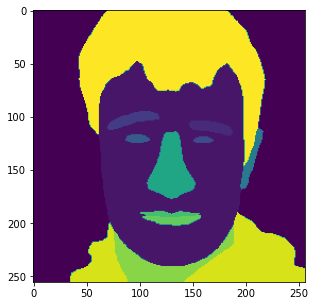

Mask:  17 0


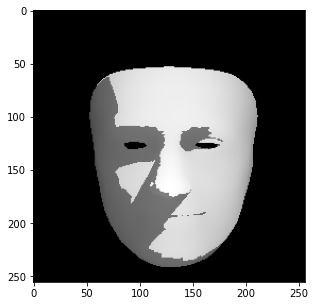

Shadows:  255 0


FileNotFoundError: [Errno 2] No such file or directory: '/data/mint/sampling/Generated_reshadow_mintomax/log=Masked_Face_woclip+BgNoHead+shadow_256_cfg=Masked_Face_woclip+BgNoHead+shadow_256.yaml_steps250/ema_085000/valid/shadow/reverse_sampling//src=60065.jpg/dst=60000.jpg/Lerp_1000/n_frames=20/res_frame0.png'

In [4]:
# Dataset
data_path = '/data/mint/DPM_Dataset/ffhq_256_with_anno/'
set_ = 'valid'
mask_path = f'{data_path}/face_segment/{set_}/anno/'
shadows_path = f'{data_path}/shadow_masks/{set_}/'

# Sampling
reshadow_path = '/data/mint/sampling/Generated_reshadow_mintomax/log=Masked_Face_woclip+BgNoHead+shadow_256_cfg=Masked_Face_woclip+BgNoHead+shadow_256.yaml_steps250/ema_085000/valid/shadow/reverse_sampling/'
img_id = '60065'
n_frames = 20

face = f'{data_path}/ffhq_256/{set_}/{img_id}.jpg'
face_img = Image.open(face)
print("Face: ", np.max(face_img), np.min(face_img))

mask = f'{mask_path}/anno_{img_id}.png'
mask_img = Image.open(mask)
plt.figure(figsize=(5, 5))
plt.imshow(np.array(mask_img))
plt.show()
print("Mask: ", np.max(mask_img), np.min(mask_img))

shadows = f'{shadows_path}/{img_id}.png'
shadows_img = Image.open(shadows)
plt.figure(figsize=(5, 5))
plt.imshow(np.array(shadows_img))
plt.show()
print("Shadows: ", np.max(shadows_img), np.min(shadows_img))

reshadow_img = [Image.open(f'{reshadow_path}/src={img_id}.jpg/dst=60000.jpg/Lerp_1000/n_frames={n_frames}/res_frame{f}.png') for f in range(n_frames)]
print("Reshadow: ", np.max(reshadow_img[1]), np.min(reshadow_img[1]))

sd = get_shadow_diff(img1=reshadow_img[2], img2=reshadow_img[-1], c_type=c_type)
m = face_segment('faceseg_faceskin&nose&mouth&eyebrows', mask_img)

def create_image_grid(images, n_rows):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)
    return grid_image


c_type = 'L'
# c_type = 'RGB'
# Compute Shadow Difference
shadow_diff = get_shadow_diff(face_img, reshadow_img[-1], c_type=c_type)
print("Shape: ", shadow_diff.shape)
print("Shadow Diff: ", np.max(shadow_diff), np.min(shadow_diff))
print("Unique: ", np.unique(shadow_diff))

out = []
reshadow_img = [face_img] + reshadow_img
for i in range(len(reshadow_img)):
    # out.append(get_shadow_diff(img1=face_img, img2=reshadow_img[i], c_type=c_type))
    out.append(get_shadow_diff(img1=reshadow_img[2], img2=reshadow_img[i], c_type=c_type))

plt.figure(figsize=(5, 5))
# plt.imshow(out[-1])
plt.imshow(out[-1], cmap='gray')
plt.show()




out_grid = create_image_grid([np.array(tmp.convert(c_type)) for tmp in reshadow_img], n_rows=3)
plt.figure(figsize=(30, 30))
# plt.imshow(out_grid)
plt.imshow(out_grid, cmap='gray')
plt.show()

out_grid = create_image_grid(out, n_rows=3)
plt.figure(figsize=(30, 30))
# plt.imshow(out_grid)
plt.imshow(out_grid, cmap='gray')
plt.show()

255 0
0.35686274509803917 -0.4588235294117647


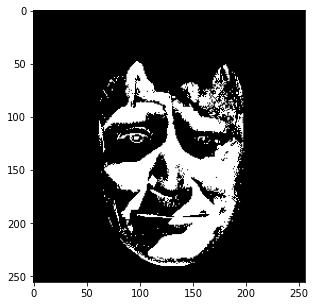

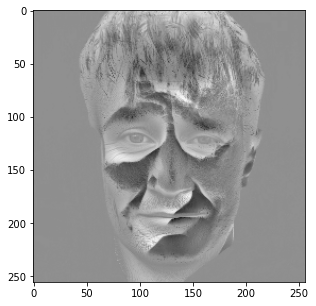

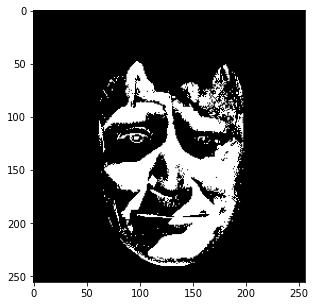

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'medianBlur'
> Overload resolution failed:
>  - src data type = 0 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


<Figure size 360x360 with 0 Axes>

In [ ]:
# tmp = np.array(reshadow_img[-1].convert(c_type))/255.0 - np.array(reshadow_img[2].convert(c_type))/255.0
tmp = np.array(reshadow_img[2].convert(c_type))/255.0 - np.array(reshadow_img[-1].convert(c_type))/255.0
print(np.max(out[-1]), np.min(out[-1]))
print(np.max(tmp), np.min(tmp))
plt.figure(figsize=(5, 5))
plt.imshow((255 - np.abs(out[-1]))*m > 128, cmap='gray')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow((tmp + 0.5) * 255, cmap='gray')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow((((tmp + 0.5) * 255) < 128) * m, cmap='gray')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(cv2.medianBlur((((tmp + 0.5)) < 0), 5) * m, cmap='gray')
plt.show()


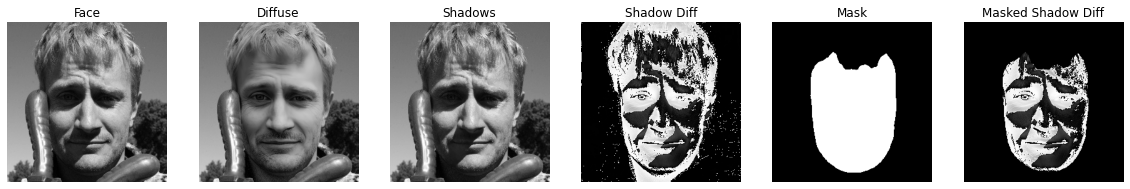

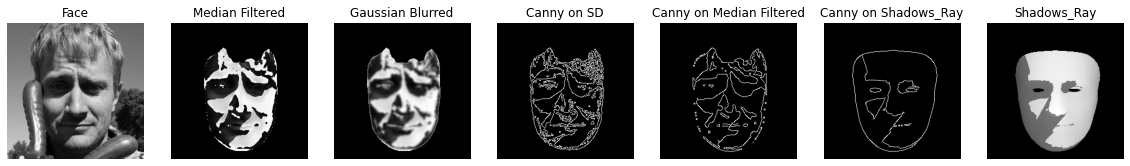

[  0  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
 

In [ ]:
def plot_subplot(imgs, titles, cmap='gray'):
    fig, axs = plt.subplots(1, len(imgs), figsize=(20, 20))
    for i, (img, title) in enumerate(zip(imgs, titles)):
        axs[i].imshow(img, cmap=cmap)
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

# img_plot = np.concatenate([face_img.convert('L'), reshadow_img[2].convert('L'), reshadow_img[-1].convert('L'), sd, m * 255, sd * m], axis=1)
# plt.figure(figsize=(20, 20))
# plt.imshow(img_plot, cmap='gray')
# plt.show()
plot_subplot([face_img.convert('L'), reshadow_img[2].convert('L'), reshadow_img[-1].convert('L'), sd, m * 255, sd * m], ['Face', 'Diffuse', 'Shadows', 'Shadow Diff', 'Mask', 'Masked Shadow Diff'])

sd = sd * m
# Apply median filtering
gaussian_blurred = cv2.GaussianBlur(sd, (9, 9), 0)
median_filtered = cv2.medianBlur(sd, 5)

# Apply errosion
kernel = np.ones((3, 3), np.uint8) 
  
# Using cv2.erode() method  
sd_erode = cv2.erode((255 - sd) * m, kernel, cv2.BORDER_REFLECT)  
sd_dilate = cv2.dilate((255 - sd) * m, kernel, cv2.BORDER_REFLECT)  


plot_subplot([face_img.convert('L'), 
              np.abs(255-median_filtered) * m, 
              np.abs(255-gaussian_blurred) * m,
              cv2.Canny(sd, 100, 200),
              cv2.Canny(np.abs(255-median_filtered) * m, 100, 200),
              cv2.Canny(np.array(shadows_img.convert('L')), 100, 200),
              shadows_img.convert('L'),
              
            ]
             , ['Face', 'Median Filtered', 'Gaussian Blurred', 'Canny on SD', 'Canny on Median Filtered', 'Canny on Shadows_Ray', 'Shadows_Ray'])

# plt.figure(figsize=(20, 20))
# plt.imshow(np.concatenate((face_img.convert('L'), 
#                            (255 - sd) * m, 
#                            sd_erode, 
#                            sd_dilate, 
#                            (255-median_filtered) * m, 
#                            (255-gaussian_blurred) * m, 
#                            shadows_img.convert('L'),
#                            cv2.Canny(sd, 100, 200),
#                            cv2.Canny((255-median_filtered) * m, 100, 200),
#                            cv2.Canny(np.array(shadows_img.convert('L')), 100, 200),
#                         ), axis=1), cmap='gray')
# plt.show()


print(np.unique(shadows_img))
print(np.unique(np.abs(255 - sd)))

[#] Laplacian on Shadow_Ray


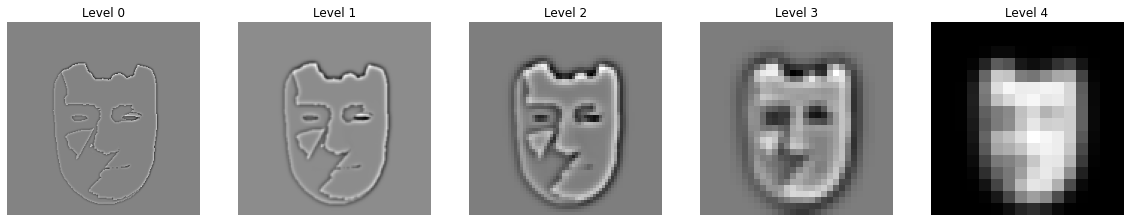

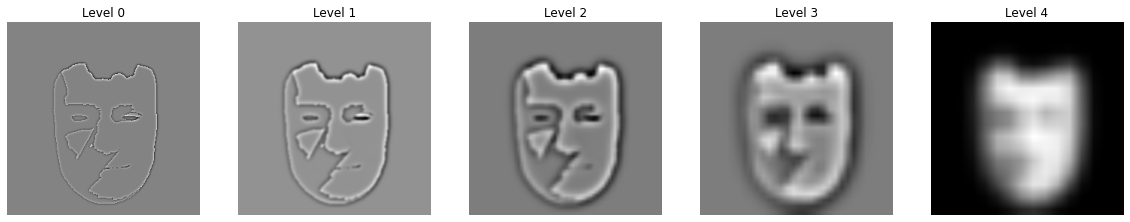

[#] Laplacian on SD


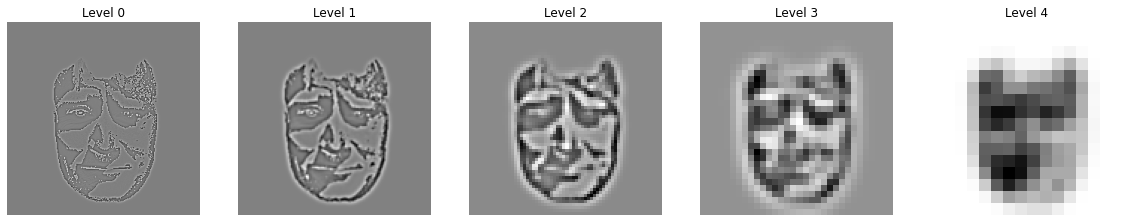

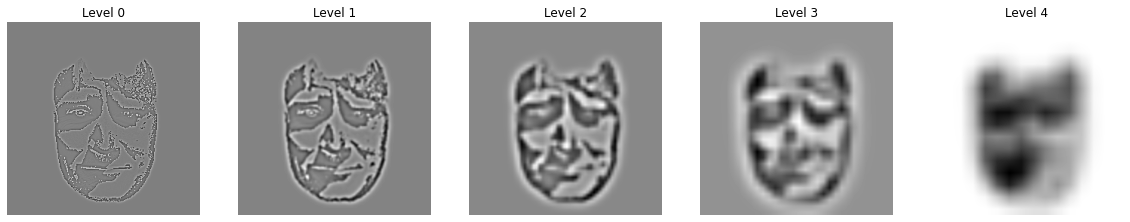

[#] Laplacian on Median Filtered


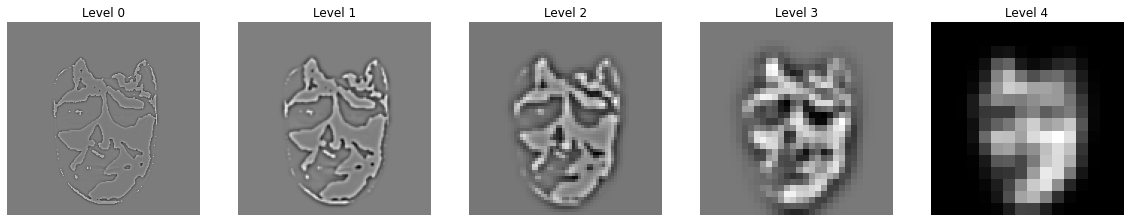

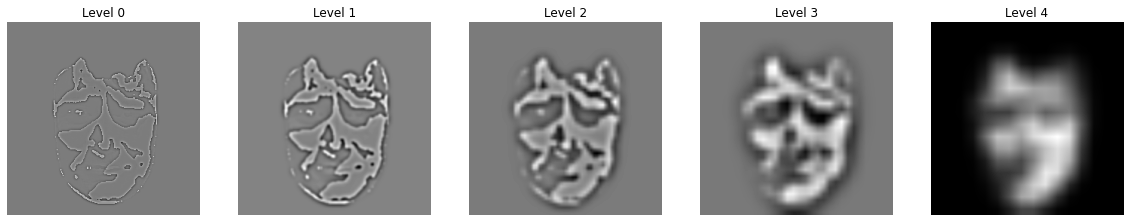

[#] Laplacian on Gaussian Blurred


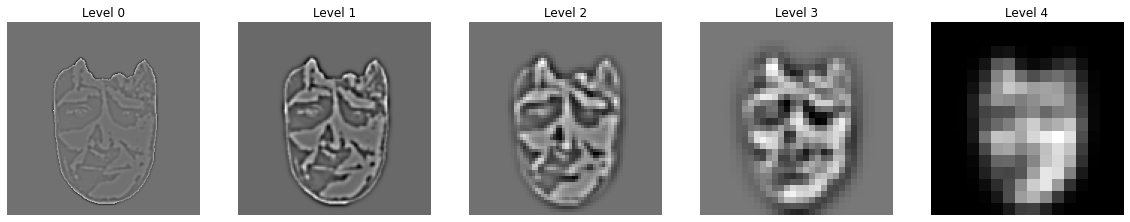

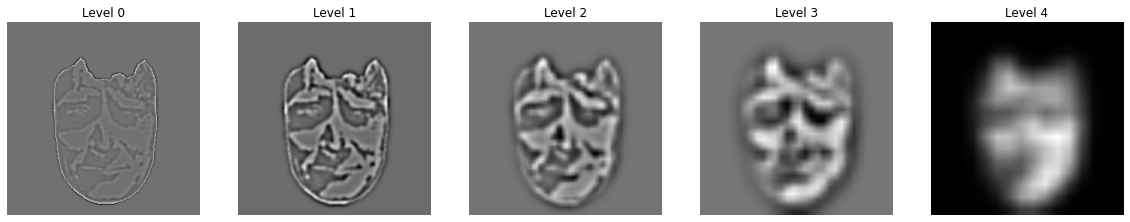

In [ ]:
def create_gaussian_pyramid(img, level=5):
  pys = [img]
  for i in range(level-1):
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.resize(img, (int(img.shape[1] / 2), int(img.shape[0] / 2)), interpolation=cv2.INTER_AREA)
    pys.append(img)
  return pys

def create_laplacian_pyramid(img, level=5):
  pys = create_gaussian_pyramid(img, level)
  for i in range(level-1):
    pys[i] = pys[i] - cv2.resize(pys[i+1], (pys[i].shape[1], pys[i].shape[0]))
  return pys

plvl = 5
print("[#] Laplacian on Shadow_Ray")
lap = create_laplacian_pyramid((np.array(shadows_img.convert('L'))/255.0) * m, plvl)
plot_subplot(lap, [f'Level {i}' for i in range(5)], cmap='gray')
plot_subplot([cv2.resize(lap[i], (lap[0].shape[1], lap[0].shape[0])) for i in range(len(lap))], [f'Level {i}' for i in range(len(lap))], cmap='gray')

print("[#] Laplacian on SD")
lap = create_laplacian_pyramid(np.array(255 - sd)/255.0, plvl)
plot_subplot(lap, [f'Level {i}' for i in range(5)], cmap='gray')
plot_subplot([cv2.resize(lap[i], (lap[0].shape[1], lap[0].shape[0])) for i in range(len(lap))], [f'Level {i}' for i in range(len(lap))], cmap='gray')

print("[#] Laplacian on Median Filtered")
lap = create_laplacian_pyramid(np.array((255-median_filtered) * m)/255.0, plvl)
plot_subplot(lap, [f'Level {i}' for i in range(5)], cmap='gray')
plot_subplot([cv2.resize(lap[i], (lap[0].shape[1], lap[0].shape[0])) for i in range(len(lap))], [f'Level {i}' for i in range(len(lap))], cmap='gray')

print("[#] Laplacian on Gaussian Blurred")
lap = create_laplacian_pyramid(np.array((255-gaussian_blurred) * m)/255.0, plvl)
plot_subplot(lap, [f'Level {i}' for i in range(5)], cmap='gray')
plot_subplot([cv2.resize(lap[i], (lap[0].shape[1], lap[0].shape[0])) for i in range(len(lap))], [f'Level {i}' for i in range(len(lap))], cmap='gray')


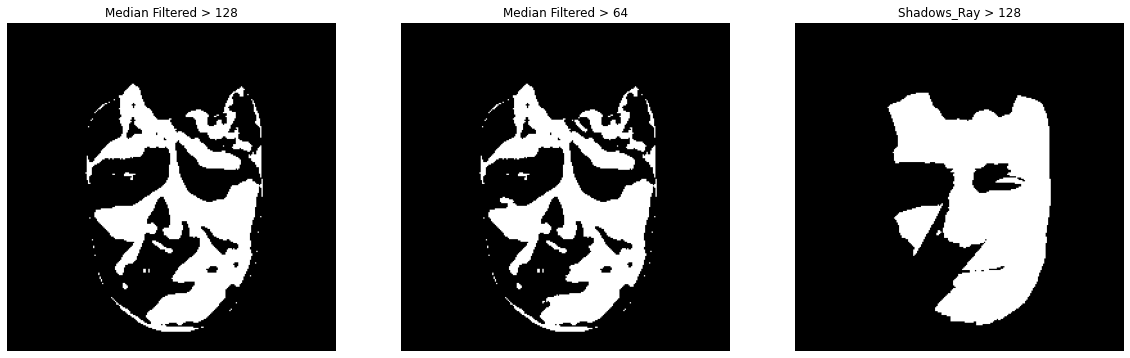

In [ ]:
plot_subplot([
        (np.abs(255-median_filtered) * m) > 128,
        (np.abs(255-median_filtered) * m) > 64,
        (np.abs(np.array(shadows_img.convert('L'))) * m) > 128,
    ], 
             
             ['Median Filtered > 128', 'Median Filtered > 64', 'Shadows_Ray > 128'], cmap='gray')

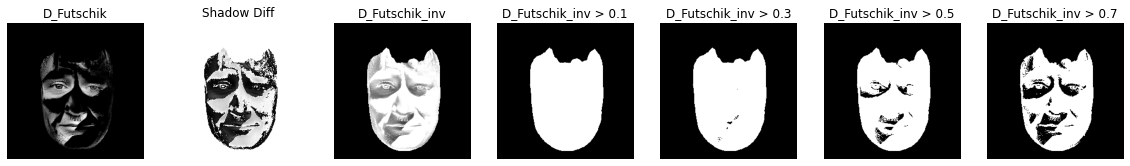

In [ ]:
shadow = reshadow_img[-1]
diffuse = reshadow_img[2]

plot_subplot(
    [
        np.maximum(np.minimum(1 - np.array(shadow.convert('L'))/(np.array(diffuse.convert('L')) + 1e-8), 1), 0) * m,
        (255 - sd),
        np.abs(1 - np.maximum(np.minimum(1 - np.array(shadow.convert('L'))/(np.array(diffuse.convert('L')) + 1e-8), 1), 0)) * m,
        ((np.abs(1 - np.maximum(np.minimum(1 - np.array(shadow.convert('L'))/(np.array(diffuse.convert('L')) + 1e-8), 1), 0)) * m) > 0.1),
        ((np.abs(1 - np.maximum(np.minimum(1 - np.array(shadow.convert('L'))/(np.array(diffuse.convert('L')) + 1e-8), 1), 0)) * m) > 0.3),
        ((np.abs(1 - np.maximum(np.minimum(1 - np.array(shadow.convert('L'))/(np.array(diffuse.convert('L')) + 1e-8), 1), 0)) * m) > 0.5),
        ((np.abs(1 - np.maximum(np.minimum(1 - np.array(shadow.convert('L'))/(np.array(diffuse.convert('L')) + 1e-8), 1), 0)) * m) > 0.7),
    ],
    
    ['D_Futschik', 'Shadow Diff', 'D_Futschik_inv', 'D_Futschik_inv > 0.1', 'D_Futschik_inv > 0.3', 'D_Futschik_inv > 0.5', 'D_Futschik_inv > 0.7'],
)

255 0
(224, 224)


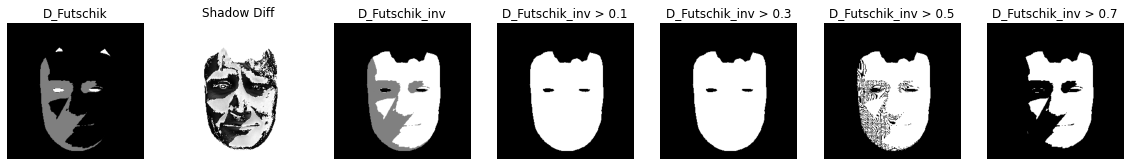

In [ ]:
diffuse_shadows_img = Image.open('./diffuse_sd_.png')
print(np.max(diffuse_shadows_img), np.min(diffuse_shadows_img))
shadow = shadows_img
diffuse = diffuse_shadows_img
print(diffuse.size)
diffuse = diffuse.resize(shadow.size)

plot_subplot(
    [
        np.maximum(np.minimum(1 - np.array(shadow.convert('L'))/(np.array(diffuse.convert('L')) + 1e-8), 1), 0) * m,
        (255 - sd),
        np.abs(1 - np.maximum(np.minimum(1 - np.array(shadow.convert('L'))/(np.array(diffuse.convert('L')) + 1e-8), 1), 0)) * m,
        ((np.abs(1 - np.maximum(np.minimum(1 - np.array(shadow.convert('L'))/(np.array(diffuse.convert('L')) + 1e-8), 1), 0)) * m) > 0.1),
        ((np.abs(1 - np.maximum(np.minimum(1 - np.array(shadow.convert('L'))/(np.array(diffuse.convert('L')) + 1e-8), 1), 0)) * m) > 0.3),
        ((np.abs(1 - np.maximum(np.minimum(1 - np.array(shadow.convert('L'))/(np.array(diffuse.convert('L')) + 1e-8), 1), 0)) * m) > 0.5),
        ((np.abs(1 - np.maximum(np.minimum(1 - np.array(shadow.convert('L'))/(np.array(diffuse.convert('L')) + 1e-8), 1), 0)) * m) > 0.7),
    ],
    
    ['D_Futschik', 'Shadow Diff', 'D_Futschik_inv', 'D_Futschik_inv > 0.1', 'D_Futschik_inv > 0.3', 'D_Futschik_inv > 0.5', 'D_Futschik_inv > 0.7'],
)
